In [74]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import Holt
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [79]:
pathfile = "C:\\Users\\User\\Downloads\\OxCGRT_Download_280420_162625_Full.csv"
data = pd.read_csv(pathfile, parse_dates=['Date'])
min_cases = 100

In [80]:
# data[(data['corona_days']>=israel_day)&(data['StringencyIndexForDisplay']<israel_stringency)]['StringencyIndexForDisplay'].unique()

In [81]:
class naiveModel:
    def __init__(df, p):
        self.stringency_df = df
        self.tau = p.tau
        self.init_infected = p.init_infected
        self.df = self.calc_df()
        
#     # st.cache
#     def get_file(self):
#         return pd.read_csv(pathfile, parse_dates=['Date'])
    
    def calc_r(self, detected):
        epsilon = 1e-06
        detected = detected
        r_values = np.array([(detected[0] / (self.init_infected + epsilon) - 1) * tau])
        for t in range(1, len(detected)):
            if t <= self.tau:
                r_value = (detected[t] / (detected[t - 1] + epsilon) - 1) * tau
            elif t > tau:
                r_value = (detected[t] / (
                            detected[t - 1] - detected[t - self.tau] + detected[t - self.tau - 1] + epsilon) - 1) * self.tau
            r_values = np.append(r_values, max(r_value, 0))
            r_adj = np.convolve(r_values, np.ones(int(self.tau, )) / int(self.tau), mode='full')[:len(detected)]
            r_adj = np.clip(r_adj, 0, 100)
        self.r_values, self.r_adj, self.r0d = r_values, r_adj, r_adj
    
    def norm_r(self, df):
        # calculate corona days and cutoff
        df = df[df['ConfirmedCases'] >= self.min_cases]
        df['day0'] = df.groupby('CountryName')['Date'].transform(min)
        df['corona_days'] = (df['Date'] - df['day0']).dt.days

        # get todays Israel day - and current R and S
        israel_day = df[df['CountryName']=='Israel']['corona_days'].max()
        israel_stringency = df[(df['CountryName']=='Israel')&(df['corona_days']==israel_day)]['StringencyIndexForDisplay'].max()
        israel_r = data[(data['CountryName']=='Israel')&(data['corona_days']==israel_day)]['r_adj'].max()

        # Normalize countries Rs to today's Israels R
        countryd_r = df[(df['corona_days']==israel_day)][['CountryName','r_adj']]
        countryd_r['norm_r'] = israel_r - countryd_r['r_adj']
        df = pd.merge(df, countryd_r[['CountryName','norm_r']])
        df['r_adjn'] = df['r_adj'] +  df['norm_r']
        return df
    
    def calc_df(self):
        df = self.stringency_df
        df = df.groupby('CountryName')['ConfirmedCases'].transform(lambda x: self.calc_r(x.values))
        df = self.norm_r(df)
        return df
    
    # logic for choosing countries is external
    # expecting input of type: df[df.CountryName.isin(countryList)]
    @static
    def avgCountries(df):
        countries_avg = df.groupby('corona_days').mean()
        return countries_avg
    

# data[(data['corona_days']>=israel_day)].groupby('CountryName')['StringencyIndexForDisplay'].count()

In [82]:
# data[(data['corona_days']>=israel_day)&(data['StringencyIndexForDisplay']<israel_stringency)]

In [118]:
def calc_r(detected, tau, init_infected):
    epsilon = 1e-06
    len_in = len(detected)
    r_values = np.array(
        [(detected[0] / (init_infected + epsilon) - 1) * tau])
    for t in range(1, len(detected)):
        if t <= tau:  # Ephraim
            r_value = (detected[t] - detected[t - 1]) / \
                       (detected[t - 1]) * tau
        elif t > tau:
            r_value = (detected[t] - detected[t - 1]) / \
                       (detected[t - 1] - detected[t - tau]+ epsilon) * tau
        r_values = np.append(r_values, max(r_value, 0))
    r_values = np.nan_to_num(r_values,nan=0.001,posinf=0.001,neginf=0.001)
    r_values = np.clip(r_values, 0.001, 15) 
    r_st = []
    for i in np.arange(len(r_values)):
        aleft = r_values[np.max([0, i - 2]):i] 
        aright = r_values[(i+1 ):(i +3)] 
        conc = np.concatenate((aleft, aright))
        tmpmean = np.mean(conc)
#         print(tmpmean)
        score = abs(r_values[i]/tmpmean)
        if (score > 2.0 and r_values[i] > np.max(conc)): 
            r_st = np.append(r_st, tmpmean)
        else:
            r_st = np.append(r_st, r_values[i])        
    double_model = ExponentialSmoothing( r_st, trend='add').fit(smoothing_level=0.20)
    ysmooth = double_model.fittedvalues 
    ysmooth[ysmooth<=0] = 0.0000001
#     print('ysmooth',ysmooth)
    r_adj = ysmooth 
#     print(len_in-len(r_adj))
    r_adj = np.pad(r_adj, (len_in-len(r_adj),), 'constant', constant_values=(0))
    return r_adj

In [119]:
len(calc_r(data.loc[data['CountryName']=='Israel','ConfirmedCases'].values,14, 0.))

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


119

In [131]:
data['r_adj'] = data.groupby('CountryName')['ConfirmedCases'].transform(lambda x: calc_r(x.values,14,50))

C:\ProgramData\Miniconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\ProgramData\Miniconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\ProgramData\Miniconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\ProgramData\Miniconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\ProgramData\Miniconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\ProgramData\Miniconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check ml

In [225]:
# calculate corona days and cutoff
data = data[data['ConfirmedCases'] >= min_cases]
data['day0'] = data.groupby('CountryName')['Date'].transform(min)
data['corona_days'] = (data['Date'] - data['day0']).dt.days

# get todays Israel day - and current R and S
israel_day = data[data['CountryName']=='Israel']['corona_days'].max()
israel_stringency = data[(data['CountryName']=='Israel')&(data['corona_days']==israel_day)]['StringencyIndexForDisplay'].max()
israel_r = data[(data['CountryName']=='Israel')&(data['corona_days']==israel_day)]['r_adj'].max()

# Normalize countries Rs to today's Israels R
countryd_r = data[(data['corona_days']==israel_day)][['CountryName','r_adj']]
countryd_r['norm_r'] = israel_r - countryd_r['r_adj']
data = pd.merge(data, countryd_r[['CountryName','norm_r']])
data['r_adjn'] = data['r_adj'] +  data['norm_r']

In [233]:
# subselect group by S logic to implement ... 
# subselect = 
# data = data[subselect]

# calcualte average RNorm by day:
Rnorm = data.groupby('corona_days', as_index=False)['r_adj'].mean()

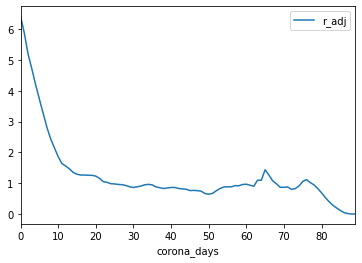

In [235]:
Rnorm.set_index('corona_days').plot()

In [140]:
data['max_r'] = data.groupby('CountryName')['r_adj'].transform(max)

In [147]:
max_r_day = data[data['r_adj']==data['max_r']][['CountryName','Date']]
max_r_day = max_r_day.rename(columns={'Date':'maxr_date'})

In [150]:
data = pd.merge(data, max_r_day, left_on=['CountryName'], right_on=['CountryName'])

In [153]:
data = data[data['Date']>data['maxr_date']]

In [156]:
data['dR'] = data.groupby('CountryName')['r_adj'].transform(lambda x: x - x.shift(1))

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [158]:
data['dS'] = data.groupby('CountryName')['StringencyIndexForDisplay'].transform(lambda x: x - x.shift(1))
# data['r_adjlag']

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [159]:
regdata = data[['CountryName', 'dR', 'dS', 'corona_days', 'StringencyIndexForDisplay', 'r_adj']]

In [162]:
import statsmodels.api as sm

In [172]:
# x_vars = ['StringencyIndexForDisplay', 'corona_days']
x_vars = ['corona_days']
y_var = ['r_adj']
regdata2 = regdata.copy()
regdata2 = regdata2[y_var + x_vars].dropna()
y = regdata2[y_var]
X = regdata2[x_vars]
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  r_adj   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     886.9
Date:                Wed, 29 Apr 2020   Prob (F-statistic):          1.69e-174
Time:                        20:41:37   Log-Likelihood:                -6698.4
No. Observations:                3619   AIC:                         1.340e+04
Df Residuals:                    3617   BIC:                         1.341e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.9602      0.053     55.545      

In [187]:
ldata = data2[['CountryName', 'r_adj', 'corona_days']].dropna()

In [222]:
import numpy as np
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
# x = np.random.uniform(low = -2*np.pi, high = 2*np.pi, size=500)
# y = np.sin(x) + np.random.normal(size=len(x))
# z = lowess(y, x)
# w = lowess(y, x, frac=1./3)
def freg(x):
    return lowess(x.r_adj.values,x.corona_days.values)
il_data = ldata.loc[ldata.CountryName=='China', ['r_adj','corona_days']]

In [223]:
il_data['est'] = lowess(il_data['r_adj'], il_data['corona_days'],frac= 1./10, it=0)[:,1]

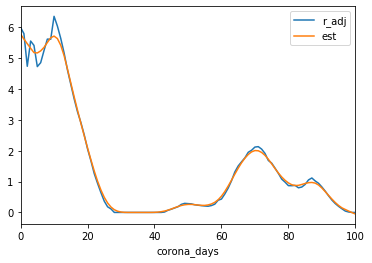

In [224]:
il_data = il_data.set_index('corona_days')
il_data[['r_adj','est']].plot()